In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from scipy import stats
import arviz as az

import functions as f

az.style.use("arviz-darkgrid")

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
filename = "2023-10"
data = pd.read_csv(f'{filename}.csv')

df = data[1:-1]
df['sasdate'] = pd.to_datetime(df['sasdate'])
df.set_index('sasdate', inplace=True)
df

/var/folders/dy/g6415zy53rnfqhdckfjskh9r0000gn/T/ipykernel_14064/3083965561.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sasdate'] = pd.to_datetime(df['sasdate'])


,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,DTCOLNVHFNM,DTCTHFNM,INVEST,VIXCLSx
sasdate,,,,,,,,,,,,,,,,,,,,,
1959-01-01,2583.560,2426.0,15.188,2.766768e+05,18235.77392,21.9665,23.3891,22.2688,31.7011,19.0149,...,18.294,10.152,2.13,2.45,2.04,NaN,6476.00,12298.00,84.2043,NaN
1959-02-01,2593.596,2434.8,15.346,2.787140e+05,18369.56308,22.3966,23.7048,22.4617,31.9337,19.1147,...,18.302,10.167,2.14,2.46,2.05,NaN,6476.00,12298.00,83.5280,NaN
1959-03-01,2610.396,2452.7,15.491,2.777753e+05,18523.05762,22.7193,23.8483,22.5719,31.9337,19.4890,...,18.289,10.185,2.15,2.45,2.07,NaN,6508.00,12349.00,81.6405,NaN
1959-04-01,2627.446,2470.0,15.435,2.833627e+05,18534.46600,23.2032,24.1927,22.9026,32.4374,19.6138,...,18.300,10.221,2.16,2.47,2.08,NaN,6620.00,12484.00,81.8099,NaN
1959-05-01,2642.720,2486.4,15.622,2.853072e+05,18679.66354,23.5528,24.3936,23.1231,32.5925,20.0130,...,18.280,10.238,2.17,2.48,2.08,95.3,6753.00,12646.00,80.7315,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-01,19074.384,15636.1,115.400,1.489005e+06,689158.00000,102.8498,101.3637,101.9376,102.9511,109.2537,...,118.279,122.441,29.33,33.97,26.15,59.0,483082.33,889095.91,5210.2067,17.3964
2023-06-01,19082.740,15654.8,115.693,1.488903e+06,690518.00000,102.2924,100.5411,100.8521,101.3834,105.4454,...,118.369,122.797,29.52,34.04,26.40,64.2,492904.98,902738.96,5188.5907,14.0327
2023-07-01,19087.005,15685.9,116.386,1.499236e+06,694415.00000,103.2895,101.4622,102.0236,102.6790,108.8802,...,118.349,123.343,29.63,34.22,26.49,71.5,496830.25,907013.82,5166.2590,13.8333


## Computing inflation from CPI

$ \pi_t = \frac{P_t - P_{t-1}}{P_{t-1}} $   or      $ \log{\pi_t} =  \log{P_t} - \log{P_{t-1}} $ 

Where $\pi_t$ is the inflation at time t and $P_t$ is the CPI at time t

In [4]:
log_cpi = np.log(df['CPIAUCSL'].values)
inflation = [0] * len(log_cpi)

for t in range(len(log_cpi[:-1])):
    inflation[t+1] = (log_cpi[t+1] - log_cpi[t]) * 1200

df['inflation'] = inflation
df = df.drop(columns=['CPIAUCSL'])

/var/folders/dy/g6415zy53rnfqhdckfjskh9r0000gn/T/ipykernel_14064/4010789755.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inflation'] = inflation


In [5]:
df

,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,DTCOLNVHFNM,DTCTHFNM,INVEST,VIXCLSx,inflation
sasdate,,,,,,,,,,,,,,,,,,,,,
1959-01-01,2583.560,2426.0,15.188,2.766768e+05,18235.77392,21.9665,23.3891,22.2688,31.7011,19.0149,...,10.152,2.13,2.45,2.04,NaN,6476.00,12298.00,84.2043,NaN,0.000000
1959-02-01,2593.596,2434.8,15.346,2.787140e+05,18369.56308,22.3966,23.7048,22.4617,31.9337,19.1147,...,10.167,2.14,2.46,2.05,NaN,6476.00,12298.00,83.5280,NaN,-0.413722
1959-03-01,2610.396,2452.7,15.491,2.777753e+05,18523.05762,22.7193,23.8483,22.5719,31.9337,19.4890,...,10.185,2.15,2.45,2.07,NaN,6508.00,12349.00,81.6405,NaN,-1.242022
1959-04-01,2627.446,2470.0,15.435,2.833627e+05,18534.46600,23.2032,24.1927,22.9026,32.4374,19.6138,...,10.221,2.16,2.47,2.08,NaN,6620.00,12484.00,81.8099,NaN,0.414150
1959-05-01,2642.720,2486.4,15.622,2.853072e+05,18679.66354,23.5528,24.3936,23.1231,32.5925,20.0130,...,10.238,2.17,2.48,2.08,95.3,6753.00,12646.00,80.7315,NaN,2.481904
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-01,19074.384,15636.1,115.400,1.489005e+06,689158.00000,102.8498,101.3637,101.9376,102.9511,109.2537,...,122.441,29.33,33.97,26.15,59.0,483082.33,889095.91,5210.2067,17.3964,1.488588
2023-06-01,19082.740,15654.8,115.693,1.488903e+06,690518.00000,102.2924,100.5411,100.8521,101.3834,105.4454,...,122.797,29.52,34.04,26.40,64.2,492904.98,902738.96,5188.5907,14.0327,2.162287
2023-07-01,19087.005,15685.9,116.386,1.499236e+06,694415.00000,103.2895,101.4622,102.0236,102.6790,108.8802,...,123.343,29.63,34.22,26.49,71.5,496830.25,907013.82,5166.2590,13.8333,2.000694


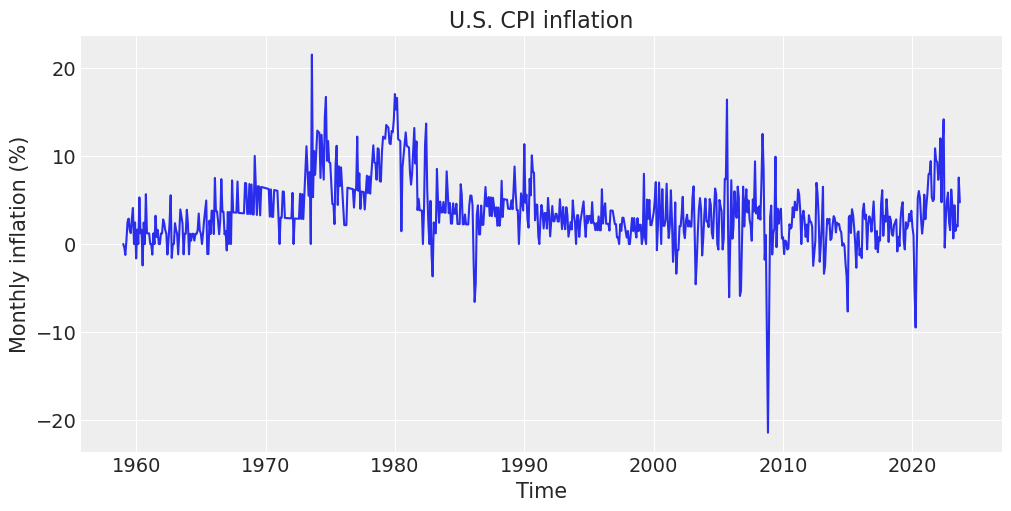

In [6]:
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(df.index, df.inflation)
plt.title("U.S. CPI inflation")
plt.xlabel("Time")
plt.ylabel("Monthly inflation (%)")
ax.grid(True)
# plt.savefig("inflation.png", dpi=150)
plt.show()

In [7]:
df.loc[df.inflation == df.inflation.min(),'inflation']

sasdate
2008-11-01   -21.436913
Name: inflation, dtype: float64

In [8]:
df["inflation"].mean()

3.6459810016778045

### EDA on inflation series

/var/folders/dy/g6415zy53rnfqhdckfjskh9r0000gn/T/ipykernel_14064/1993532872.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax1 = sns.distplot(df['inflation'],fit=stats.norm, ax=ax1)
/var/folders/dy/g6415zy53rnfqhdckfjskh9r0000gn/T/ipykernel_14064/1993532872.py:8: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


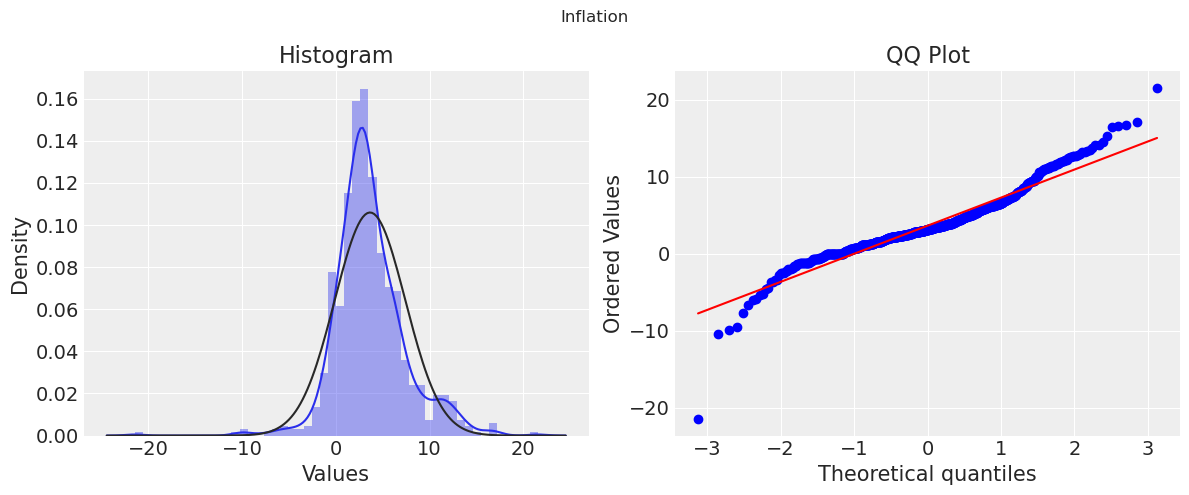

In [9]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
ax1 = sns.distplot(df['inflation'],fit=stats.norm, ax=ax1)
ax1.set_title('Histogram')
ax1.set_xlabel('Values')
res = stats.probplot(df['inflation'], plot=ax2)
ax2.set_title('QQ Plot')
fig.suptitle('Inflation')
plt.tight_layout()

/var/folders/dy/g6415zy53rnfqhdckfjskh9r0000gn/T/ipykernel_14064/389048173.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax1 = sns.distplot(df['inflation'].diff(),fit=stats.norm, ax=ax1)
/var/folders/dy/g6415zy53rnfqhdckfjskh9r0000gn/T/ipykernel_14064/389048173.py:8: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


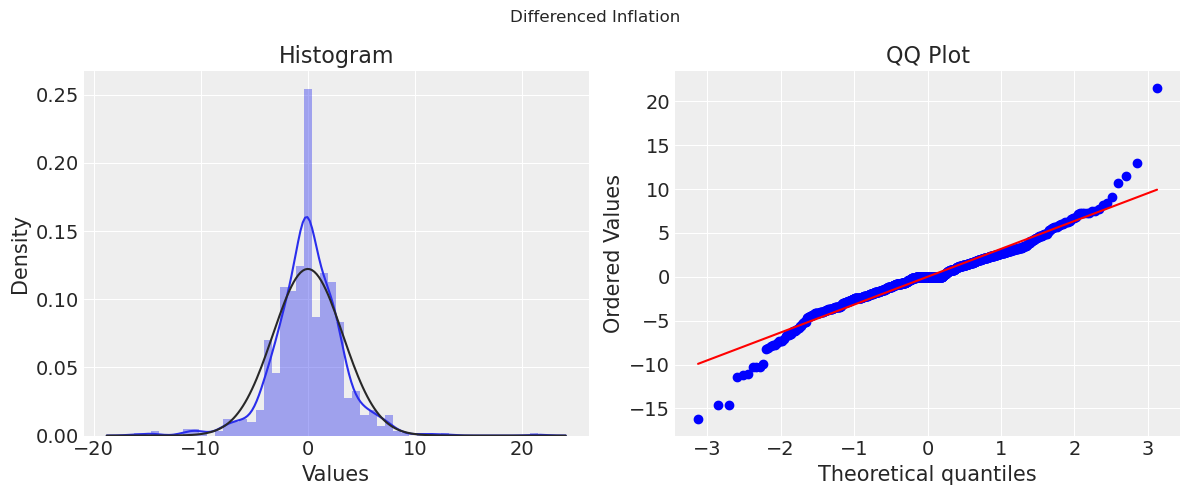

In [10]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
ax1 = sns.distplot(df['inflation'].diff(),fit=stats.norm, ax=ax1)
ax1.set_title('Histogram')
ax1.set_xlabel('Values')
res2 = stats.probplot(df['inflation'].diff().dropna(), plot=ax2)
ax2.set_title('QQ Plot')
fig.suptitle('Differenced Inflation')
plt.tight_layout()

In [15]:
from scipy.stats import shapiro
# normality test
stat, p = shapiro(df['inflation'].diff().dropna())
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
 print('Sample looks Gaussian (fail to reject H0)')
else:
 print('Sample does not look Gaussian (reject H0)')

Statistics=0.945, p=0.000
Sample does not look Gaussian (reject H0)


## Missing Values

In [27]:
nullseries = df.isnull().sum()
nullseries = nullseries[nullseries > 0]
print(nullseries)

CMRMTSPLx          1
HWI                1
HWIURATIO          1
PERMIT            12
PERMITNE          12
PERMITMW          12
PERMITS           12
PERMITW           12
ACOGNO           398
ANDENOx          109
BUSINVx            1
ISRATIOx           1
NONREVSL           1
CONSPI             1
S&P div yield      3
S&P PE ratio       2
CP3Mx              1
COMPAPFFx          1
TWEXAFEGSMTHx    168
UMCSENTx         154
DTCOLNVHFNM        1
DTCTHFNM           1
VIXCLSx           42
dtype: int64


In [101]:
clean_df = df.drop(['ACOGNO', 'TWEXAFEGSMTHx', 'UMCSENTx', 'ANDENOx', 'VIXCLSx', 'PCEPI', 'DDURRG3M086SBEA', 'DNDGRG3M086SBEA', 'DSERRG3M086SBEA'], axis=1)
clean_df = clean_df.dropna()

In [102]:
no_price_indices_df = clean_df.loc[:, ~clean_df.columns.str.contains('^CPI', case=False)]
no_price_indices_df = no_price_indices_df.loc[:, ~no_price_indices_df.columns.str.contains('^PPI', case=False)]
no_price_indices_df = no_price_indices_df.loc[:, ~no_price_indices_df.columns.str.contains('^CUSR', case=False)]
no_price_indices_df = no_price_indices_df.loc[:, ~no_price_indices_df.columns.str.contains('^WPS', case=False)]

In [103]:
clean_df = no_price_indices_df

In [104]:
clean_df.describe()

,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,EXUSUKx,EXCAUSx,OILPRICEx,CES0600000008,CES2000000008,CES3000000008,DTCOLNVHFNM,DTCTHFNM,INVEST,inflation
count,761.000000,761.000000,761.000000,7.610000e+02,761.00000,761.000000,761.000000,761.000000,761.000000,761.000000,...,761.000000,761.000000,761.000000,761.000000,761.000000,761.000000,761.000000,761.000000,761.000000,761.000000
mean,9419.666524,8039.997898,55.762016,8.180360e+05,215085.47520,67.545171,71.989487,70.754998,79.432517,66.706234,...,1.867145,1.197864,32.577059,12.470276,14.482786,11.520815,131990.059829,346496.373798,1263.521822,3.694728
std,4814.676189,3821.727244,29.204360,3.741314e+05,176726.29509,26.243649,26.711728,26.985483,22.870452,27.999211,...,0.484427,0.160201,29.239410,7.523616,8.411815,6.787944,129769.777706,331427.421693,1383.302293,3.757239
min,2695.694000,2534.500000,15.789000,2.659352e+05,18417.27084,22.100900,24.106600,23.095600,32.708700,18.241300,...,1.093100,0.951000,2.920000,2.220000,2.570000,2.130000,6877.000000,14063.000000,71.186400,-21.436913
25%,5165.514000,4601.600000,29.403000,4.913656e+05,52660.03644,45.147500,47.246500,45.210400,61.710000,42.604100,...,1.526800,1.073200,11.160000,5.220000,6.870000,4.830000,10975.000000,34790.000000,200.863800,1.560468
50%,8284.054000,7251.500000,48.247000,7.184085e+05,161366.32340,62.506000,71.275900,69.469900,80.619400,60.866300,...,1.684000,1.182800,21.759000,11.820000,13.660000,11.210000,80375.000000,188611.200000,686.073800,3.185138
75%,13570.847000,11368.100000,83.711000,1.163601e+06,354015.00000,93.982000,99.139600,98.153300,100.302100,95.989300,...,2.316500,1.323000,47.980000,18.700000,20.980000,17.290000,262969.090000,727380.460000,2047.280800,5.479462
max,22856.702000,15654.800000,115.693000,1.505373e+06,692501.00000,104.118100,110.221900,108.677700,111.785000,110.128800,...,2.815400,1.599700,133.930000,29.520000,34.040000,26.400000,492904.980000,949306.220000,5832.648400,21.525241


In [105]:
clean_df.to_pickle(f'{filename}.pkl')

## Create Lagged Variables

In [106]:
lag_df = f.create_lagged_vars(clean_df, 6) # 6 month lag
lag_df.to_pickle(f'{filename}_lag.pkl')

### Feature importance

#### Correlations (only linear)

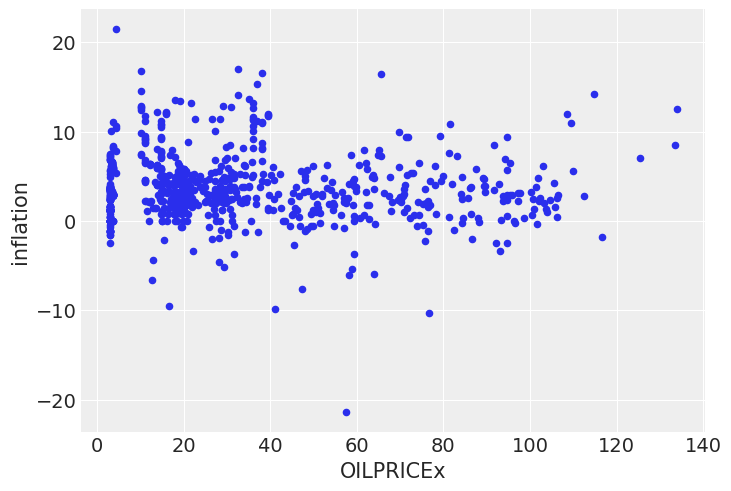

In [107]:
var = 'OILPRICEx'
scat_data = pd.concat([df['inflation'], df[var]], axis=1)
scat_data.plot.scatter(x=var, y='inflation');

### Plot feature importance

In [108]:
correlation = clean_df.corr()['inflation'].sort_values(ascending=False)
pearson_scores = correlation[2:12].sort_values(ascending=False)

p_width = np.arange(len(pearson_scores))
p_ticks = list(pearson_scores.index)

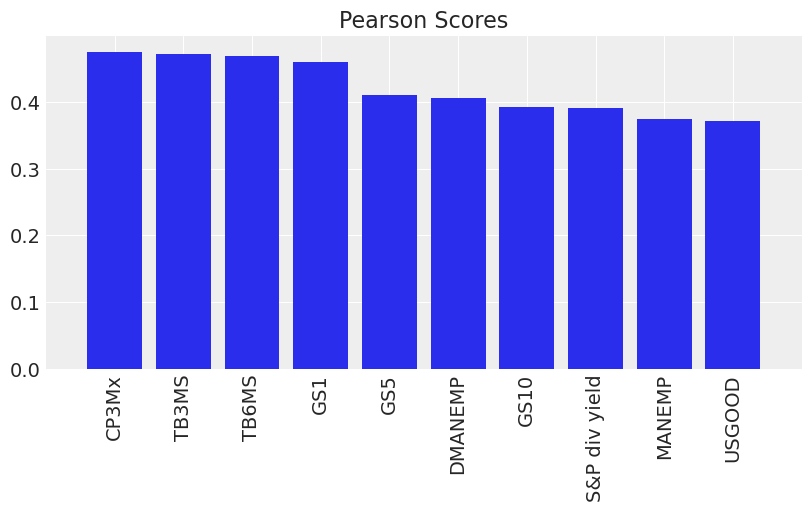

In [109]:
plt.figure(figsize=(8,5))
plt.title("Pearson Scores")
plt.bar(range(10), pearson_scores, align="center")
plt.xticks(range(10), p_ticks, rotation=90)
plt.xlim([-1, 10])
# plt.savefig("pearson_correlations.png", dpi=150)
plt.show()

/Users/MorrisHeijke/Desktop/Uni/Master/Thesis Econometrics/thesis_code/functions.py:160: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


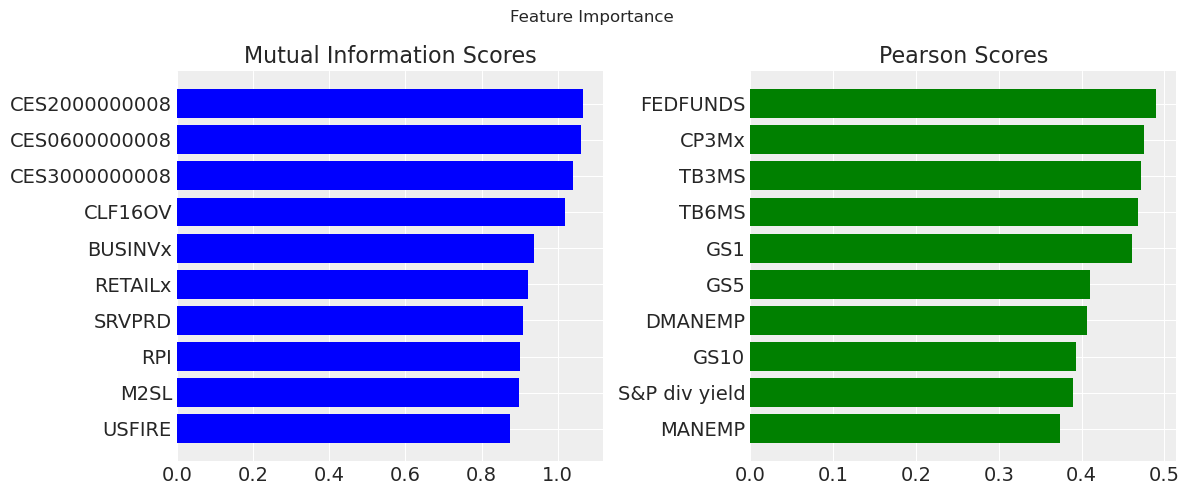

In [111]:
unlagged_df = clean_df.loc['1960-01-01':,:]
f.plot_correlations(unlagged_df, 10)
plt.savefig("MI_Pearson.png", dpi=150)

/Users/MorrisHeijke/Desktop/Uni/Master/Thesis Econometrics/thesis_code/functions.py:160: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


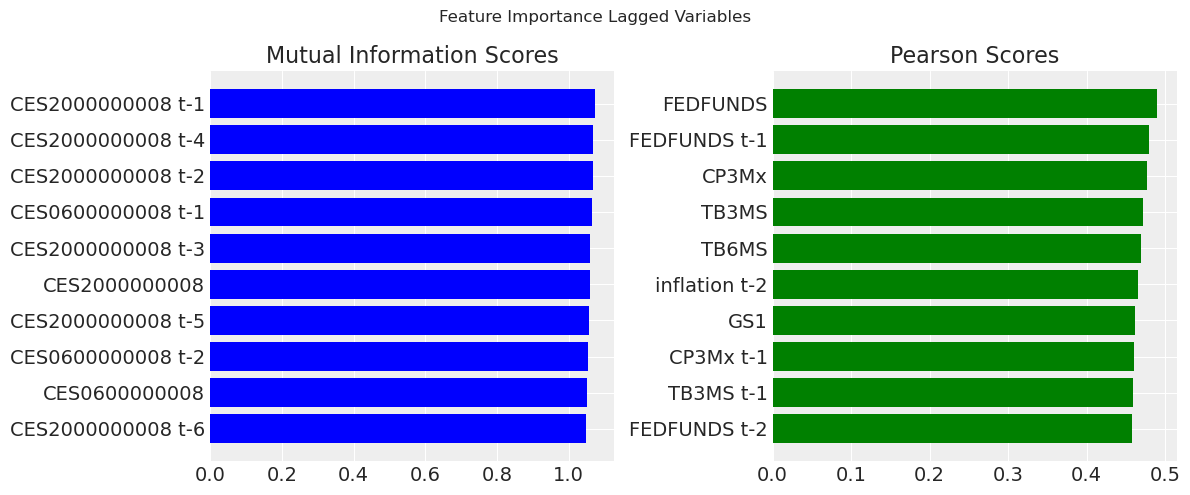

In [96]:
f.plot_correlations(lag_df, 10, title='Lagged Variables')

### Multi Collinearity

In [61]:
Y = unlagged_df.loc[:, 'inflation']
X = unlagged_df.drop(columns=['inflation'])
mi_scores = f.make_mi_scores(X, Y)

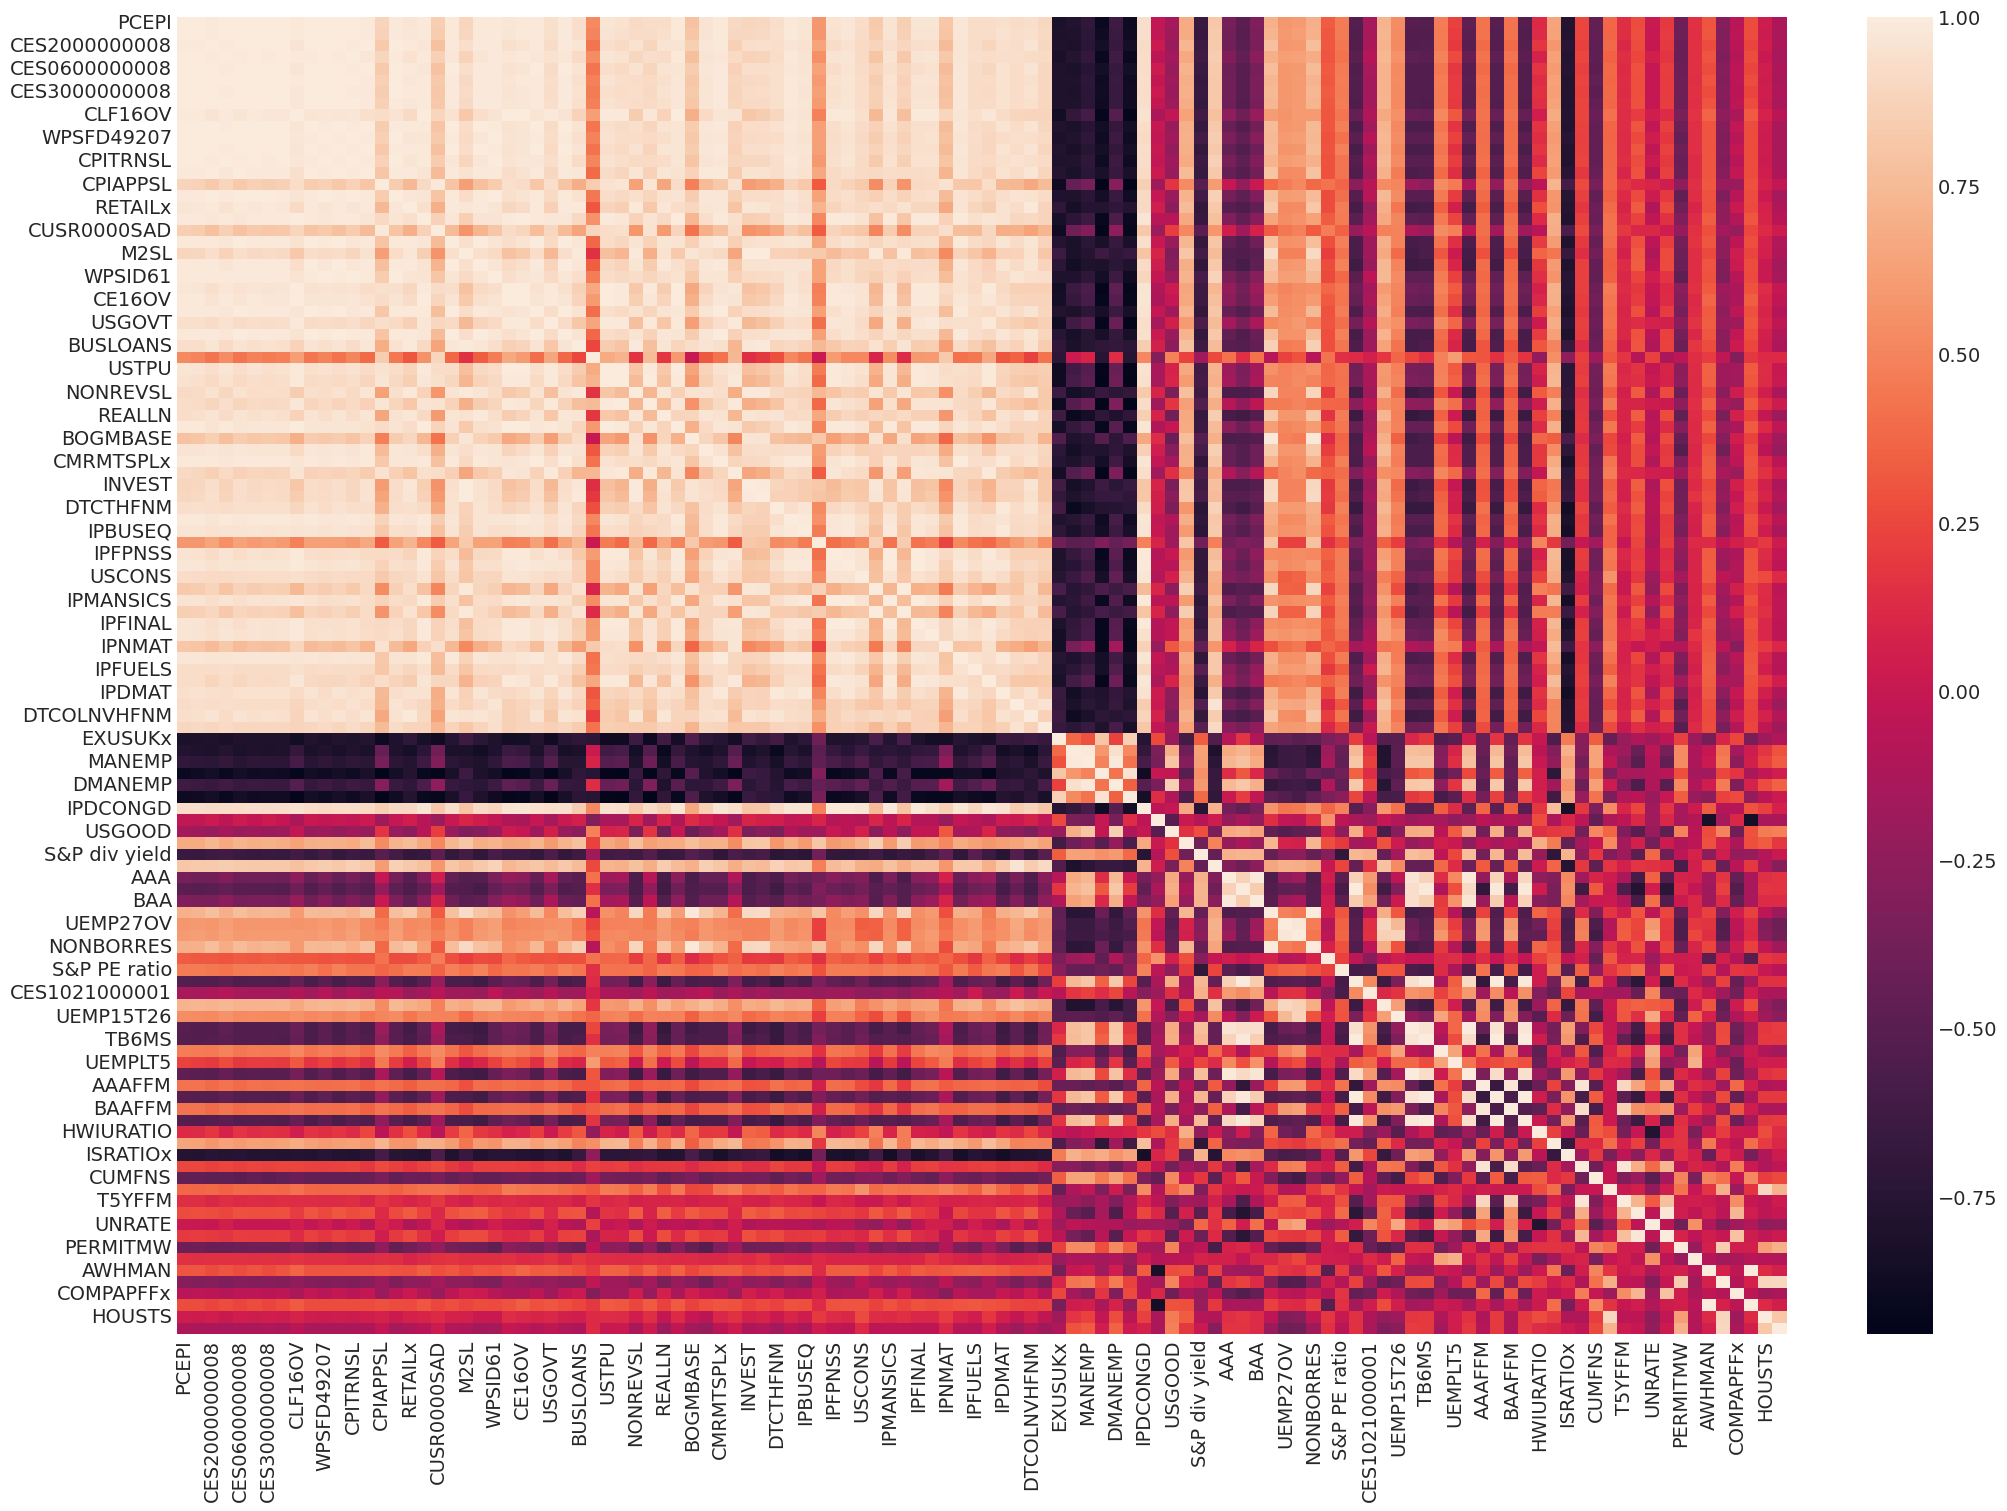

In [62]:
significant_feature = mi_scores[mi_scores>0.1]
plt.subplots(figsize=(20,15))
heatmap = sns.heatmap(data[significant_feature[1:].index].corr())
fig = heatmap.get_figure()

In [63]:
len(significant_feature)

115